# matplotlibのみで決定木を描画する

## 概要
sci-kit learnのDecisionTree系メソッド（DecisionTreeClassifierなど）には、  
Graphvizを利用して決定木を可視化する機能があります。  
Graphvizはグラフ、ネットワーク図の描画に強いライブラリでとても良いものですが  
環境構築が（時に）めちゃめちゃめんどくさいです。  
Windowsか、Macか、Linuxかでも変わってくるのもまた難題です。  
そこで、matplotlibのみでGraphvizと同等の図を出力できるようにしました。  

## アウトプットイメージ

<img src='../output/result.png'>

In [1]:
import numpy as np
import pandas as pd
from sklearn import tree
import matplotlib.patches as mpatch
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

## Irisデータセットの準備

In [2]:
data = load_iris()
X = data.data
y = data.target
feature_names = data.feature_names
target_names = data.target_names

## 決定木モデルの学習

In [3]:
model = tree.DecisionTreeClassifier(max_depth=5)
model.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## Graphvizを使った可視化

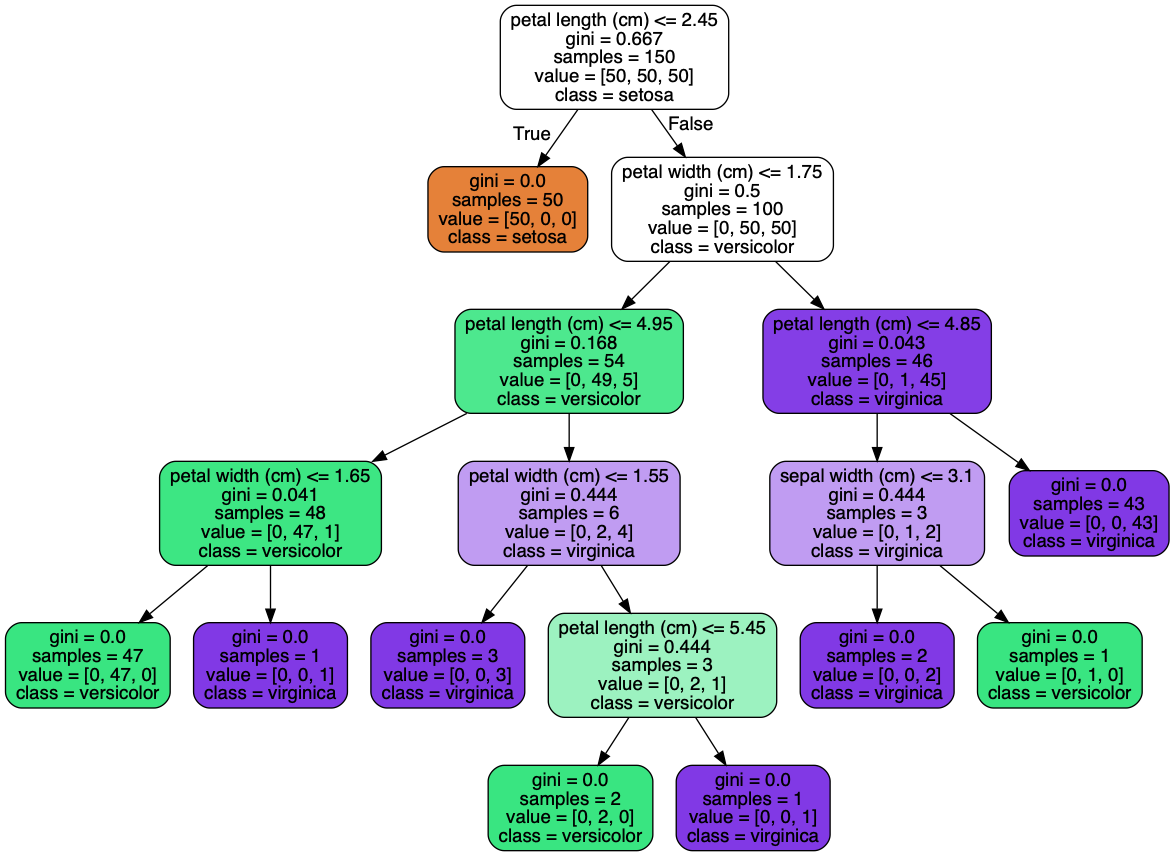

In [4]:
import pydotplus
from IPython.display import Image
# あくまで比較用
# このNotebookで提案する手法ではこれらも必要ありません

dot_data = tree.export_graphviz(
    model, 
    out_file=None,
    feature_names=feature_names,
    class_names=target_names,
    filled=True, 
    rounded=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

## export_graphvizを再現するために情報をとってくる

In [5]:
samples = model.tree_.n_node_samples
samples

array([150,  50, 100,  54,  48,  47,   1,   6,   3,   3,   2,   1,  46,
         3,   2,   1,  43])

In [6]:
values = model.tree_.value
values[:5]

array([[[50., 50., 50.]],

       [[50.,  0.,  0.]],

       [[ 0., 50., 50.]],

       [[ 0., 49.,  5.]],

       [[ 0., 47.,  1.]]])

In [7]:
model.tree_.feature
# -2は分割が発生しないnodeを表している

array([ 2, -2,  3,  2,  3, -2, -2,  3, -2,  2, -2, -2,  2,  1, -2, -2, -2])

In [8]:
features = [feature_names[i] if i >=0 else 'target' for i in model.tree_.feature]
features

['petal length (cm)',
 'target',
 'petal width (cm)',
 'petal length (cm)',
 'petal width (cm)',
 'target',
 'target',
 'petal width (cm)',
 'target',
 'petal length (cm)',
 'target',
 'target',
 'petal length (cm)',
 'sepal width (cm)',
 'target',
 'target',
 'target']

In [9]:
thresholds = model.tree_.threshold
thresholds

array([ 2.45000005, -2.        ,  1.75      ,  4.94999981,  1.6500001 ,
       -2.        , -2.        ,  1.54999995, -2.        ,  5.44999981,
       -2.        , -2.        ,  4.85000038,  3.0999999 , -2.        ,
       -2.        , -2.        ])

In [10]:
impurities = model.tree_.impurity
impurities

array([0.66666667, 0.        , 0.5       , 0.16803841, 0.04079861,
       0.        , 0.        , 0.44444444, 0.        , 0.44444444,
       0.        , 0.        , 0.04253308, 0.44444444, 0.        ,
       0.        , 0.        ])

In [11]:
criterion = model.criterion
criterion

'gini'

## 描画のためにnodeの高さを算出する

In [12]:
node_count = model.tree_.node_count
children_left = model.tree_.children_left
children_right = model.tree_.children_right

In [13]:
links = []
links_left = []
links_right = []
link = {}
for i, child_left in enumerate(children_left):
    if child_left != -1:
        link['source'] = i
        link['target'] = child_left
        links.append(link.copy())
        links_left.append(link.copy())
for i, child_right in enumerate(children_right):
    if child_right != -1:
        link['source'] = i
        link['target'] = child_right
        links.append(link.copy())
        links_right.append(link.copy())

In [14]:
def calc_nodes_height(node_count, max_depth, links):
    heights_list = list(range(node_count))
    heights_list[0] = max_depth
    k = [0]
    for i in range(node_count):
        tmp = []
        for link in links:
            if link['source'] in k:
                heights_list[link['target']] = heights_list[link['source']] - 1
                tmp.append(link['target'])
        k = tmp.copy()
        
    return heights_list

In [15]:
nodes_height = calc_nodes_height(
    model.tree_.node_count,
    model.tree_.max_depth,
    links
)
nodes_height

[5, 4, 4, 3, 2, 1, 1, 2, 1, 1, 0, 0, 3, 2, 1, 1, 2]

## 分類のclass名、indexを算出する

In [16]:
class_ids = []
for value in values:
    class_ids.append(np.argmax(value))
classes = [target_names[i] for i in class_ids]

## nodeに記載する情報をstrにする

In [17]:
texts = []
for i in range(node_count):
    if not features[i] == 'target':
        text = f'{features[i]} <= {thresholds[i]:,.2f}\n'
    else:
        text = ''
    text += f'{criterion} = {impurities[i]:.2f}\n\
samples = {samples[i]}\n\
values = {values[i]}\n\
class = {classes[i]}'
    texts.append(text)

In [18]:
# 親ノード直下の子ノードがいくつあるか数える
child_counts = []
for i in range(node_count):
    child_count = 0
    for link in links:
        if link['source'] == i:
            child_count += 1
    child_counts.append(child_count)

In [19]:
# x軸の配置を調整する
base_distance = 0.35
append_coordinate = [base_distance * -1, base_distance]
x_dict = {}
for i in range(node_count):
    x_dict[i] = None
x_dict[0] = 0
for i in range(node_count):
    tmp = 0
    for link in links:
        if link['source'] == i:
            x = x_dict[link['source']] + append_coordinate[tmp]
            height = nodes_height[link['target']]
            for j, node_height in enumerate(nodes_height):
                try:
                    if (round(height, 1) == round(node_height, 1))\
                    and (round(x_dict[j], 1) == round(x, 1)):
                        x += base_distance * 2
                except TypeError:
                    # None参照を無視する
                    pass
                    
            x_dict[link['target']] = x
            tmp += 1

In [20]:
# 親ノードと子ノードのx軸が離れすぎている場合調整する
diffs_dict = {}
for link in links:
    diff = x_dict[link['source']] - x_dict[link['target']]
    if round(diff, 1) < base_distance * -2:
        height = nodes_height[link["target"]]
        for heigh in range(height + 1):
            nodes = [i for i, x in enumerate(nodes_height) if x == heigh]
            for node in nodes:
                x_dict[node] -= base_distance

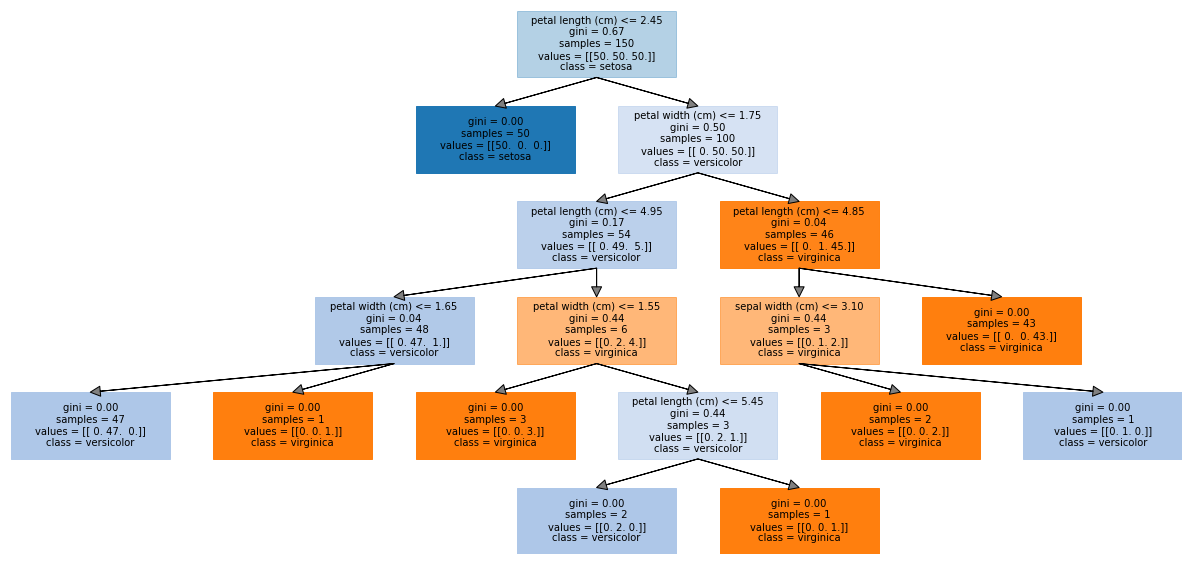

In [21]:
fig = plt.figure(
    figsize=[
        (max(x_dict.values()) - min(x_dict.values())) * 6,
        nodes_height[0] * 2
    ]
)
ax = fig.add_subplot(111)
# 不要な枠線、軸の削除
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
ax.tick_params(labelbottom="off",bottom="off")
ax.tick_params(labelleft="off",left="off")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xlim(min(x_dict.values()), max(x_dict.values()))

viz_x = {}
viz_y = {}
for i in range(node_count):
    viz_x[i] = x_dict[i]
    viz_y[i] = nodes_height[i]

rect_width = 0.55
rect_height = 0.7

for i, text in enumerate(texts):
    # nodeを表す四角形の描画
    rectangle = mpatch.Rectangle(
        (viz_x[i], viz_y[i]),
        rect_width,
        rect_height,
        color=cm.tab20(class_ids[i]),
        alpha=1 - impurities[i]
    )
    ax.add_artist(rectangle)
    
    # node内のtextの描画
    rx, ry = rectangle.get_xy()
    cx = rx + rectangle.get_width()/2.0
    cy = ry + rectangle.get_height()/2.0
    ax.annotate(text, (cx, cy), color='black', 
                fontsize=10, ha='center', va='center')

# 矢印の描画
for link  in links:
    x = x_dict[link['source']] + rect_width / 2
    y = nodes_height[link['source']]
    dx = x_dict[link['target']] + rect_width / 2
    dy = nodes_height[link['target']] + rect_height
    ax.annotate(s='', xy=(dx, dy), xytext=(x, y),
            xycoords='data',
            arrowprops=dict(
                facecolor='gray', 
                width =0.1,
                headwidth=10.0,
                headlength=10.0,
                shrink=0)
               )

ax.set_xlim(min(x_dict.values()), max(x_dict.values()) + rect_width)
_ = ax.set_ylim(min(nodes_height), max(nodes_height) + rect_height)

In [22]:
fig.savefig('../output/result.png', dpi=300)